In [1]:
#####User Tracking and Document Modeling with nCRF#####
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import scipy
from scipy import stats
from scipy import special
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    if pattern==1:
        z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id

In [3]:
####データの生成####
##データの設定
geo = 2
levels = 2
k1 = 5
k2 = np.array([4, 4, 5, 5, 6])
topic = 15
hh = 4000
v = 1000   #語彙数
Lambda = np.random.gamma(12.5, 1/0.25, hh)
pt = np.random.poisson(Lambda, hh); pt[pt < 10] = 10
pt_vec = pt[:, np.newaxis]
N = np.sum(pt)
w = np.random.poisson(np.random.gamma(10.0, 1/0.5, N)); w[w < 5] = 5
f = np.sum(w)

In [4]:
##IDとインデックスを作成
#IDを作成
u_id = np.repeat(np.arange(hh), pt)
d_id = np.repeat(np.arange(N), w)

#インデックスを作成
u_list = [i for i in range(hh)]
d_list = [i for i in range(N)]
d_vec = [i for i in range(N)]
for i in range(hh):
    u_list[i] = np.array(np.where(u_id==i)[0], dtype="int")
for i in range(N):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")
    d_vec[i] = np.repeat(1, d_list[i].shape[0])

In [5]:
####パラメータとデータの生成####
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##ノード分布を生成
    #グローバルノード分布を生成
    G1 = np.random.dirichlet(np.repeat(3.0, k1), 1).reshape(-1)
    G2 = [np.random.dirichlet(np.repeat(2.5, k2[j]), 1).reshape(-1)  for j in range(k1)]
    GT1 = G1.copy(); GT2 = G2.copy()

    #ローカルノード分布を生成
    alpha1 = 2.0
    theta1 = np.random.dirichlet(alpha1*G1, hh)
    theta2 = [np.random.dirichlet(alpha1*G2[j], hh) for j in range(k1)]
    thetat1 = theta1.copy(); thetat2 = theta2.copy()

    
    ##モデルパラメータを生成
    #トピック分布を生成
    er = 0.01
    alpha2 = 2.5
    gamma_global = np.zeros((k1, topic))
    gamma = [j for j in range(k1)]
    for j in range(k1):
        gamma_global[j, ] = np.random.dirichlet(np.repeat(0.3, topic), 1)
        gamma[j] = np.random.dirichlet(alpha2*gamma_global[j, ]+er, k2[j])
    gammat_global = gamma_global.copy()
    gammat = gamma.copy()

    #location分布を生成
    min_point = -7.5; max_point = 7.5
    target_range = np.array([-2.75, 2.75])
    longitude = np.array([min_point, max_point]); latitude = np.array([min_point, max_point])
    mu_global = np.append(np.random.uniform(longitude[0], longitude[1], k1), 
                          np.random.uniform(latitude[0], latitude[1], k1)).reshape(k1, geo, order="F")
    mu = [i for i in range(k1)]
    Cov = [i for i in range(k1)]
    for i in range(k1):
        mu0 = np.zeros((k2[i], geo))
        Cov0 = np.zeros((geo, geo, k2[i]))
        for j in range(k2[i]):
            mu0[j, ] = mu_global[i, ] + np.random.uniform(target_range[0], target_range[1], geo)
            cov_temp = np.diag(np.random.uniform(0.2, 0.7, geo))
            value = np.random.uniform(-0.6, 0.6, 1) * np.prod(np.sqrt(np.diag(cov_temp)))
            cov_temp[0, 1] = value; cov_temp[1, 0] = value
            Cov0[:, :, j] = cov_temp
        mu[i] = mu0
        Cov[i] = Cov0
    mut_global = mu_global.copy()
    mut = mu.copy(); Covt = Cov.copy()

    #単語分布を生成
    m = 25
    beta = np.repeat(0.025, v)
    phi = np.random.dirichlet(beta, topic)
    index_v = np.array(range(v))[np.max(phi, axis=0) <= (topic*m)/f]
    for j in range(index_v.shape[0]):
        phi[np.argmax(np.random.multinomial(1, np.repeat(1/topic, topic), 1)), index_v[j]] = (topic*m)/f
    phi = phi / np.sum(phi, axis=1).reshape(topic, 1)
    phit = phi.copy()


    ##潜在変数を生成
    #多項分布から潜在ノードを生成
    R1 = np.array(rmnom(theta1[u_id, ], N, k1, np.arange(N), 1)[1].todense(), dtype="int8")
    r1 = np.dot(R1, np.arange(k1))
    R2 = np.zeros((N, np.max(k2)), dtype="int8")
    r2 = np.repeat(0, N)
    index_r1 = [j for j in range(k1)]
    n = np.repeat(0, k1)
    for j in range(k1):
        index_r1[j] = np.array(np.where(r1==j)[0], dtype="int")
        n[j] = index_r1[j].shape[0]
        R2[index_r1[j], :k2[j]] = np.array(rmnom(theta2[j][u_id[index_r1[j]], ] ,n[j], k2[j], np.arange(n[j]), 1)[1].todense(), dtype="int8")
        r2[index_r1[j]] = np.dot(R2[index_r1[j], :k2[j]], np.arange(k2[j]))
    r = np.array(np.hstack((r1[:, np.newaxis], r2[:, np.newaxis])), dtype="int16")

    #トピック分布を生成
    r_vec = r[d_id, ]
    index_r2 = [j for j in range(k1)]
    gamma_dt = np.zeros((f, topic))
    for j in range(k1):
        index_r2[j] = np.array(np.where(r_vec[:, 0]==j)[0], dtype="int")
        gamma_dt[index_r2[j], ] = gamma[j][r_vec[index_r2[j], 1], ]

    #多項分布からトピックを生成
    out = rmnom(gamma_dt, f, topic, np.arange(f), 1)
    Z = np.array(out[1].todense(), dtype="int8")
    z_vec = np.array(out[0], dtype="int16")


    ##データを生成
    #多変量正規分布からlocationを生成
    no = np.arange(N)
    y = np.zeros((N, geo))
    for i in range(k1):
        index1 = index_r1[i]
        for j in range(k2[i]):
            index2 = np.where(r[index1, 1]==j)[0]
            y[index1[index2], ] = np.random.multivariate_normal(mu[i][j, ], Cov[i][:, :, j], index2.shape[0])

    #多項分布から単語を生成
    wd = np.array(np.repeat(0, f), dtype="int16")
    for i in range(N):
        index = d_list[i]
        wd[index] = np.array(rmnom(phi[z_vec[index], ], w[i], v, np.arange(w[i]), 0), dtype="int16")

    #単語がすべて生成されればbreak
    if np.unique(wd).shape[0]==v:
        break

1
2
3
4
5
6
7


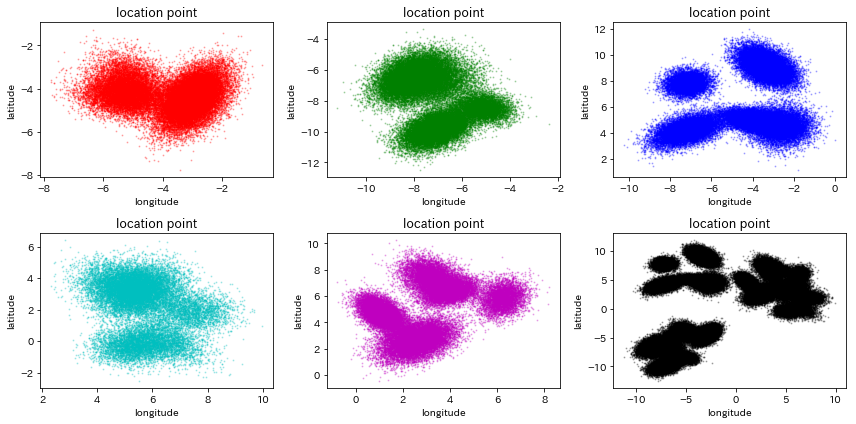

In [6]:
#locatio分布を可視化
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig = plt.figure(figsize=(12.0, 6.0))
for j in range(k1):
    index = index_r1[j]
    ax = fig.add_subplot(2, 3, j+1)
    ax.scatter(y[index, 0], y[index, 1], s=1, c=colorlist[j], alpha=0.25, linewidths="1", edgecolors=colorlist[j])
    plt.title("location point", fontsize=12.5)
    plt.xlabel("longitude")
    plt.ylabel("latitude")
ax = fig.add_subplot(2, 3, k1+1)
ax.scatter(y[:, 0], y[:, 1], s=1, c=colorlist[k1+1], alpha=0.25, linewidths="1", edgecolors=colorlist[k1+1])
plt.title("location point", fontsize=12.5)
plt.xlabel("longitude")
plt.ylabel("latitude")
fig.tight_layout()
plt.show()

In [7]:
#単語のインデックスを作成
wd_list = [i for i in range(v)]
wd_vec = [i for i in range(v)]
word_freq = np.repeat(0, v)
for i in range(v):
    wd_list[i] = np.array(np.where(wd==i)[0], dtype="int")
    wd_vec[i] = np.repeat(1, wd_list[i].shape[0])
    word_freq[i] = wd_list[i].shape[0]

In [24]:
####マルコフ連鎖モンテカルロ法でパラメータを推定####
##多変量正規分布の密度関数
def dmv(x, mu, Cov, k):
    er = x - mu
    Cov_inv = np.linalg.inv(Cov) 
    LLo = 1 / (np.sqrt(pow((2 * np.pi), k) * np.linalg.det(Cov))) * np.exp(-1/2 * np.dot(np.dot(er, Cov_inv) *er, np.ones(k)))
    return(LLo)

##アルゴリズムの設定
max_k1 = 7
R = 2000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10
target_iter = 50
sample_rate = np.repeat(1/N, N)

In [25]:
##事前分布の設定
#nCRFの集中度パラメータ
alpha1 = 0.1; beta1 = 0.1
alpha2 = 0.1; beta2 = 0.25

#モデルパラメータの事前分布
Deltabar = np.repeat(0.0, geo)
ADelta = 0.01
nu = geo + 1
V = nu * np.diag(np.ones(geo))
pi1 = 0.25
pi2 = 0.1
pi3 = 0.01

#パラメータサンプリング時の誤差
delta0 = np.repeat(0.0, geo)
tau0 = np.diag(np.repeat(0.5, geo))
omega0 = 2.5
er0 = 0.05

In [26]:
##パラメータの真値
#ノード構造の真値
levels = 2
k1 = 5
k2 = np.array([4, 4, 5, 5, 6])

#潜在変数の真値
Ri1 = np.array(R1.copy(), dtype="int")
r1 = np.dot(Ri1, np.arange(k1))
Ri2 = np.array(R2.copy(), dtype="int")
r2 = np.dot(Ri2, np.arange(np.max(k2)))
r = np.hstack((r1[:, np.newaxis], r2[:, np.newaxis]))
Zi = Z.copy()
z = np.dot(Zi, np.arange(topic))

#モデルパラメータの真値
G1 = GT1.copy(); G2 = GT2.copy()
theta1 = thetat1.copy(); theta2 = thetat2.copy()
gamma_global = gammat_global.copy()
gamma = gammat.copy()
mu = mut.copy(); Cov = Covt.copy()
phi = phit.copy()

#location分布の真値
mu_global = mut_global.copy()
Cov_global = np.zeros((geo, geo, k1))
for j in range(k1):
    index = np.array(np.where(Ri1[:, j]==0)[0], dtype="int")
    er = y[index, ] - mu_global[j, ]
    Cov_global[:, :, j] = np.dot(er.T, er) / index.shape[0]

In [27]:
##初期値の設定
#ノード構造の初期値
levels = 2
k1 = 4
k2 = np.repeat(1, k1)

#モデルパラメータの初期値
alpha01 = 2.0; alpha02 = 2.5
G1 = np.random.dirichlet(np.repeat(5.0, k1), 1).reshape(-1)
G2 = [np.random.dirichlet(np.repeat(5.0, k2[j]), 1).reshape(-1)  for j in range(k1)]
GT1 = G1.copy(); GT2 = G2.copy()
theta1 = np.random.dirichlet(alpha01*G1, hh)
theta2 = [np.random.dirichlet(alpha01*G2[j], hh) for j in range(k1)]
gamma_global = np.random.dirichlet(np.repeat(5.0, topic), k1)
gamma = [gamma_global[j, ] for j in range(k1)]
mu_global = np.zeros((k1, geo))
Cov_global = np.zeros((geo, geo, k1))
for j in range(k1):
    mu_global[j, ] = np.random.multivariate_normal(np.mean(y, axis=0), np.diag(np.repeat(25.0, geo)), 1)
    Cov_global[:, :, j] = np.diag(np.repeat(0.25, geo))
mu = [mu_global[j, ] for j in range(k1)]
Cov = [Cov_global[:, :, np.array([j])] for j in range(k1)]
phi = np.random.dirichlet(np.repeat(5.0, v), topic)

#潜在ノードの初期値
Ri1 = np.array(rmnom(theta1[u_id, ], N, k1, np.arange(N), 1)[1].todense(), dtype="int8")
r1 = np.dot(Ri1, np.arange(k1))
Ri2 = np.zeros((N, np.max(k2)), dtype="int8")
r2 = np.repeat(0, N)
index_r1 = [j for j in range(k1)]
for j in range(k1):
    index = np.array(np.where(Ri1[:, j]==1)[0], dtype="int")
    n = index.shape[0]
    Ri2[index, :k2[j]] = np.array(rmnom(theta2[j][u_id[index], ], n, k2[j], np.arange(n), 1)[1].todense(), dtype="int8")
    r2[index] = np.dot(R2[index, :k2[j]], np.arange(k2[j]))

#トピックの初期値
out = rmnom(np.full((f, topic), 1/topic), f, topic, np.arange(f), 1)
Zi = np.array(out[1].todense(), dtype="int8")
z_vec = np.array(out[0], dtype="int16")

old_setting = np.seterr(divide='raise', invalid='raise')

In [28]:
##nCRFのグローバルノードとローカルノードの頻度を定義
#パラメータの格納用配列
M1 = np.sum(Ri1, axis=0)
M2 = [i for i in range(k1)]
m1 = np.zeros((hh, k1), dtype="int")
m2 = [np.zeros((hh, k2[i]), dtype="int") for i in range(k1)]

#グローバルノードの頻度
freq = np.dot(Ri2.T, Ri1).T
for j in range(k1):
    M2[j] = freq[j, ][:k2[j]]
    
#ローカルノードの頻度
for i in range(hh):
    index = u_list[i]
    m1[i, ] = np.sum(Ri1[index, ], axis=0)
    freq = np.dot(Ri2[index, ].T, Ri1[index, ]).T
    for j in range(k1):
        m2[j][i, ] = freq[j, ][:k2[j]]
        
#階層的事前分布を定義
Prior1 = m1/(pt_vec+alpha1) + alpha1/(pt_vec+alpha1)*M1/(N+beta1); Prior1 = np.hstack((Prior1, 1-np.sum(Prior1, axis=1)[:, np.newaxis]))
Prior2 = [j for j in range(k1)]
for j in range(k1):
    freq = np.sum(m2[j], axis=1)[:, np.newaxis]
    Prior2[j] = m2[j]/(freq+alpha2) + alpha2/(freq+alpha2)*M2[j]/(np.sum(M2[j])+beta2)
    Prior2[j] = np.hstack((Prior2[j], 1-np.sum(Prior2[j], axis=1)[:, np.newaxis]))
    
#文書ごとのトピック頻度を数える
z_freq = np.zeros((N, topic), dtype="int")
for i in range(N):
    z_freq[i, ] = np.dot(Zi[d_list[i], ].T, d_vec[i])

In [29]:
##パラメータの格納用配列
#モデルパラメータの格納用配列
MU1 = [j for j in range(int(R/keep))]
MU2 = [j for j in range(int(R/keep))]
COV1 = [j for j in range(int(R/keep))]
COV2 = [j for j in range(int(R/keep))]
GAMMA1 = [j for j in range(int(R/keep))]
GAMMA2 = [j for j in range(int(R/keep))]
PHI = np.zeros((topic, v, int(R/keep)))

#潜在変数の格納用配列
SEG1 = np.zeros((N, int(R/keep)), dtype="int8")
SEG2 = np.zeros((N, int(R/keep)), dtype="int")
TOPIC = np.zeros((f, topic), dtype="int")

In [30]:
##学習データの真値の対数尤度
#ノード構造の真値
levels0 = 2
k01 = 5
k02 = np.array([4, 4, 5, 5, 6])

#locationの対数尤度
LL01 = 0
for i in range(k01):
    index = np.array(np.where(R1[:, i])[0], dtype="int")
    Lho_dmv = np.zeros((index.shape[0], k02[i]))
    for j in range(k02[i]):
        Lho_dmv[:, j] = dmv(y[index, ], mut[i][j, ], Covt[i][:, :, j], geo)
    LL01 += np.sum(np.log(np.sum(thetat2[i][u_id[index], ] * Lho_dmv, axis=1)))
print(LL01)

#トピックモデルの対数尤度
R_vec01 = R1[d_id, ]; R_vec02 = R2[d_id, ]
r_vec02 = np.dot(R_vec02, np.arange(np.max(k02)))
Lho_topic = np.zeros((f, topic))
for j in range(k01):
    index = np.array(np.where(R_vec01[:, j]==1)[0], dtype="int")
    Lho_topic[index, ] = gammat[j][r_vec02[index], ] * (phit.T)[wd[index], ]
LL02 = np.sum(np.log(np.sum(Lho_topic, axis=1)))
print(LL02)

#対数尤度の和
LL0 = LL01 + LL02
print(LL0)

-532484.5251758433
-18827241.861794557
-19359726.3869704


In [31]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##level1のノードをサンプリング
    #新しいパラメータをサンプリング
    if k1 <= max_k1:
        k_level1 = k1 + 1
        target = np.argmax(np.random.multinomial(1, sample_rate, 1))
        mu_new = np.vstack((mu_global, y[target, ] + np.random.multivariate_normal(delta0, tau0, 1)))
        Cov_new = np.zeros((geo, geo, k1+1))
        Cov_new[:, :, :k1] = Cov_global; Cov_new[:, :, k1] = np.diag(np.repeat(0.5, geo))
        gamma0 = np.sum(Zi[d_list[target], ], axis=0) / w[target]
        gamma_new = np.vstack((gamma_global, np.random.dirichlet(omega0*gamma0 + er0, 1)))
    else:
        k_level1 = mu_global.shape[0]
        mu_new = mu_global.copy()
        Cov_new = Cov_global.copy()
        gamma_new = gamma_global.copy()

    #同時分布の尤度を定義
    Lho11 = np.zeros((N, k_level1))
    for i in range(k_level1):
        Lho11[:, i] = dmv(y, mu_new[i, ], Cov_new[:, :, i], geo)
    Lho11[np.isnan(Lho11)] = 0
    Lho12 = np.exp(np.dot(z_freq, np.log(gamma_new).T))
    Lho1 = Prior1[u_id, ] * Lho11 * Lho12
    
    #多項分布からノードをサンプリング
    Prob1 = Lho1 / np.sum(Lho1, axis=1)[:, np.newaxis]
    out1 = rmnom(Prob1, N, k_level1, no, 1)
    Ri1 = np.array(out1[1].todense(), dtype="int")
    
    #出現があるノードのみ採択
    index_k1 = np.array(np.where(np.sum(Ri1, axis=0) > 0)[0], dtype="int")
    Ri1 = Ri1[:, index_k1]
    r1 = np.dot(Ri1, np.arange(index_k1.shape[0]))
    if index_k1.shape[0] > k1:
        k2 = np.append(k2, 1)
    k1 = index_k1.shape[0]
    
        
    ##nCRFのグローバルノードとローカルノードの頻度を定義
    #パラメータの格納用配列
    M1 = np.sum(Ri1, axis=0)
    M2 = [i for i in range(k1)]
    m1 = np.zeros((hh, k1), dtype="int")
    m2 = [np.zeros((hh, k2[i]), dtype="int") for i in range(k1)]
    index_r1 = [i for i in range(k1)]
    n = np.repeat(0, k1)

    #グローバルノードの頻度
    freq = np.dot(Ri2.T, Ri1).T
    for j in range(k1):
        index_r1[j] = np.array(np.where(Ri1[:, j]==1)[0], dtype="int")
        n[j] = index_r1[j].shape[0]
        M2[j] = freq[j, ][:k2[j]]

    #ローカルノードの頻度
    for i in range(hh):
        index = u_list[i]
        m1[i, ] = np.sum(Ri1[index, ], axis=0)
        freq = np.dot(Ri2[index, ].T, Ri1[index, ]).T
        for j in range(k1):
            m2[j][i, ] = freq[j, ][:k2[j]]

    #階層的事前分布を定義
    alpha11 = alpha1/k1; beta11 = beta1/k1
    alpha21 = M1/N * alpha2; beta21 = M1/N * beta2
    Prior1 = m1/(pt_vec+alpha11) + alpha11/(pt_vec+alpha11)*M1/(N+beta11)
    if k1 <= max_k1:
        Prior1 = np.hstack((Prior1, 1-np.sum(Prior1, axis=1)[:, np.newaxis]))
    Prior2 = [j for j in range(k1)]
    for j in range(k1):
        freq = np.sum(m2[j], axis=1)[:, np.newaxis]
        Prior2[j] = m2[j]/(freq+alpha21[j]) + alpha21[j]/(freq+alpha21[j])*M2[j]/(np.sum(M2[j])+beta21[j])
        Prior2[j] = np.hstack((Prior2[j], 1-np.sum(Prior2[j], axis=1)[:, np.newaxis]))


    ##Level1のパラメータをサンプリング
    #新しいモデルパラメータ
    if k1 > mu_global.shape[0]:
        flag = 1
    else:
        flag = 0

    #ノードごとにパラメータを更新
    for j in range(k1):
        #多変量正規分布から期待値をサンプリング
        index = index_r1[j]
        y_target = y[index, ] 
        mu_par = np.sum(y_target, axis=0) / (n[j] + ADelta)
        Sigma = np.kron(Cov_new[:, :, j], 1/n[j])
        mu_new[j, ] = np.random.multivariate_normal(mu_par, Sigma, 1)

        #逆ウィシャート分布から分散共分散行列をサンプリング
        er = y_target - mu_new[j, ]
        IW_R = np.dot(er.T, er) + V
        Sn = n[j] + nu
        Cov_new[:, :, j] = scipy.stats.invwishart.rvs(Sn, IW_R, 1)

        #ディリクレ分布からトピック分布をサンプリング
        wsum = np.sum(z_freq[index, ], axis=0) + pi1
        gamma_new[j, ] = np.random.dirichlet(wsum, 1)

    #パラメータをコピー
    index_target = np.arange(k1)
    mu_global = mu_new[index_target, ]
    Cov_global = Cov_new[:, :, index_target]
    gamma_global = gamma_new[index_target, ]


    ##Level2のノードをサンプリング
    #新しいパラメータの設定とパラメータの格納用配列を定義
    if flag==1:
        mu.append(mu_global[np.array([k1-1]), ])
        Cov.append(Cov_global[:, :, k1-1].reshape(geo, geo, 1))
        gamma.append(gamma_global[np.array([k1-1]), ])
    Ri2 = np.zeros((N, np.max(k2)+1), dtype="int")
    r2 = np.repeat(0, N)


    ##Level2のノードをサンプリング
    #パラメータの格納用配列
    Lho_dmv = np.zeros((N, np.max(k2)))
    Ri2 = np.zeros((N, np.max(k2)+1), dtype="int")

    #新しいパラメータをサンプリング
    for i in range(k1):
        index = index_r1[i]
        target = index[np.argmax(np.random.multinomial(1, np.repeat(1/n[i], n[i]), 1))]
        mu_new = np.vstack((mu[i], y[target, ] + np.random.multivariate_normal(delta0, tau0, 1)))
        Cov_new = np.zeros((geo, geo, k2[i]+1))
        Cov_new[:, :, :k2[i]] = Cov[i]; Cov_new[:, :, k2[i]] = np.diag(np.repeat(0.5, geo))
        gamma0 = np.sum(Zi[d_list[target], ], axis=0) / w[target]
        gamma_new = np.vstack((gamma[i], np.random.dirichlet(gamma0 + er0, 1)))

        #同時分布の尤度を定義
        Lho21 = np.zeros((n[i], k2[i]+1))
        for j in range(k2[i]+1):
            Lho21[:, j] = dmv(y[index, ], mu_new[j, ], Cov_new[:, :, j], geo)
        Lho21[np.isnan(Lho21)] = 0
        Lho22 = np.exp(np.dot(z_freq[index, ], np.log(gamma_new).T))
        Lho2 = Prior2[i][u_id[index], ] * Lho21 * Lho22

        #多項分布からノードをサンプリング
        Prob2 = Lho2 / np.sum(Lho2, axis=1)[:, np.newaxis]
        out2 = rmnom(Prob2, n[i], k2[i]+1, np.arange(n[i]), 1)
        Nord2 = np.array(out2[1].todense(), dtype="int")
        
        #出現があるノードのみ採択
        index_k2 = np.array(np.where(np.sum(Nord2, axis=0) > 0)[0], dtype="int")
        k2[i] = index_k2.shape[0]
        Ri2[index, :k2[i]] = Nord2[:, index_k2]
        mu[i] = mu_new[index_k2, ]
        Cov[i] = Cov_new[:, :, index_k2]
        gamma[i] = gamma_new[index_k2, ]
        

    #ローカルノードの頻度を更新
    k2 = k2[np.arange(k1)]
    Ri2 = Ri2[:, np.arange(np.max(k2))]
    r2 = np.dot(Ri2, np.arange(np.max(k2)))
    freq = np.dot(Ri2.T, Ri1).T
    for j in range(k1):
        M2[j] = freq[j, ][:k2[j]]


    ##ノードごとにlocation分布のパラメータをサンプリング
    #多変量正規分布から期待値をサンプリング
    for i in range(k1):
        index = index_r1[i]
        for j in range(k2[i]):
            y_target = y[index, ] * Ri2[index, j][:, np.newaxis]
            mu_par = np.sum(y_target, axis=0) / (M2[i][j] + ADelta)
            Sigma = np.kron(Cov[i][:, :, j], 1/M2[i][j])
            mu[i][j, ] = np.random.multivariate_normal(mu_par, Sigma, 1)

            #逆ウィシャート分布から分散共分散行列をサンプリング
            er = y_target - mu[i][j, ]*Ri2[index, j][:, np.newaxis]
            IW_R = np.dot(er.T, er) + V
            Sn = M2[i][j, ] + nu
            Cov[i][:, :, j] = scipy.stats.invwishart.rvs(Sn, IW_R, 1)


    ##ノードごとにトピックをサンプリング
    #ノード割当を単語idに割り当てる
    R_vec1 = Ri1[d_id, ]; R_vec2 = Ri2[d_id, ]
    r_vec2 = np.dot(R_vec2, np.arange(np.max(k2)))

    #トピックの割当確率を定義
    Lho_topic = np.zeros((f, topic))
    index_r2 = [j for j in range(k1)]
    for j in range(k1):
        index_r2[j] = np.array(np.where(R_vec1[:, j]==1)[0], dtype="int")
        Lho_topic[index_r2[j], ] = gamma[j][r_vec2[index_r2[j]], ] * (phi.T)[wd[index_r2[j]], ]
    Prob = Lho_topic / np.sum(Lho_topic, axis=1)[:, np.newaxis]

    #多項分布からトピックをサンプリング
    out = rmnom(Prob, f, topic, np.arange(f), 1)
    Zi = np.array(out[1].todense(), dtype="int")
    z = np.array(out[0], dtype="int")
    
    #文書ごとのトピック頻度を数える
    z_freq = np.zeros((N, topic), dtype="int")
    for i in range(N):
        z_freq[i, ] = np.dot(Zi[d_list[i], ].T, d_vec[i])


    ##トピックモデルのパラメータをサンプリング
    #トピック分布をサンプリング
    for i in range(k1):
        wsum = np.dot(Zi.T, R_vec2[:, :k2[i]] * R_vec1[:, i][:, np.newaxis]).T + pi2
        for j in range(k2[i]):
            gamma[i][j, ] = np.random.dirichlet(wsum[j, ], 1).reshape(-1)

    #単語分布をサンプリング
    vsum = np.zeros((topic, v))
    for j in range(v):
        vsum[:, j] = np.dot(Zi[wd_list[j], ].T, wd_vec[j])
    for j in range(topic):
        phi[j, ] = np.random.dirichlet(vsum[j, ] + pi3, 1).reshape(-1)


    ##サンプリング結果の格納と表示
    #サンプリング結果の格納
    if rp%keep==0:
        mkeep = int(rp/keep)
        MU1[mkeep] = mu_global
        MU2[mkeep] = mu
        COV1[mkeep] = Cov_global
        COV2[mkeep] = Cov
        GAMMA1[mkeep] = gamma_global
        GAMMA2[mkeep] = gamma
        PHI[:, :, mkeep] = phi
        SEG1[:, mkeep] = r1
        SEG2[:, mkeep] = r2
        
    #トピック割当はバーンイン期間を超えたら格納
    if rp%keep==0 & rp >= burnin:
        TOPIC = TOPIC + Zi

    if rp%disp==0:
        #学習データの対数尤度
        Lho_dmv = np.zeros((N, np.max(k2)))
        for i in range(k1):
            index = index_r1[i]
            for j in range(k2[i]):
                Lho_dmv[index, j] = Prior2[i][u_id[index], j] * dmv(y[index, ], mu[i][j, ], Cov[i][:, :, j], geo)
        LL1 = np.sum(np.log(np.sum(Lho_dmv[np.sum(Lho_dmv, axis=1) > 0, ], axis=1)))
        LL2 = np.sum(np.log(np.sum(Lho_topic, axis=1)))
        LL = LL1 + LL2

        #サンプリング結果の表示
        print(rp)
        print(k1)
        print(k2)
        print(M1)
        print(np.round([LL1, LL2, LL, LL01, LL02, LL0], 1))

0
5
[2 2 2 2 1]
[82470 35750 33067 48226   576]
[  -887740.3 -27672722.2 -28560462.4   -532484.5 -18827241.9 -19359726.4]
10
5
[2 3 2 2 3]
[75969 35567 37218 40933 10402]
[  -791404.5 -21404113.1 -22195517.6   -532484.5 -18827241.9 -19359726.4]
20
5
[2 3 1 2 2]
[75105 35575 36232 40899 12278]
[  -782972.9 -21270681.9 -22053654.8   -532484.5 -18827241.9 -19359726.4]
30
5
[2 2 1 2 2]
[74871 35580 35836 40884 12918]
[  -780205.  -21242876.7 -22023081.7   -532484.5 -18827241.9 -19359726.4]
40
7
[2 1 1 2 2 2 4]
[74728 22536 35744 39785 13167 13254   875]
[  -769046.9 -21188885.  -21957931.8   -532484.5 -18827241.9 -19359726.4]
50
7
[2 1 1 2 2 3 5]
[74617 23173 35716 35772 13330 13408  4073]
[  -753527.6 -20981692.9 -21735220.5   -532484.5 -18827241.9 -19359726.4]
60
7
[3 2 1 2 2 3 4]
[74503 23124 35739 35717 13471 13598  3937]
[  -747428.9 -20928556.2 -21675985.1   -532484.5 -18827241.9 -19359726.4]
70
8
[3 2 1 3 2 3 4 3]
[68715 22920 35761 35680 13594 13808  3932  5679]
[  -734593.1 -20854

570
8
[6 3 8 4 2 5 3 7]
[41861 20545 42940 34762 18685 14520  5678 21098]
[  -525853.2 -19182433.9 -19708287.1   -532484.5 -18827241.9 -19359726.4]
580
8
[6 3 8 4 2 4 3 7]
[41860 20546 42944 34762 18688 14522  5675 21092]
[  -525794.7 -19182156.5 -19707951.2   -532484.5 -18827241.9 -19359726.4]
590
8
[6 3 8 4 2 4 3 7]
[41858 20548 42955 34762 18683 14521  5674 21088]
[  -525836.1 -19181606.5 -19707442.5   -532484.5 -18827241.9 -19359726.4]
600
8
[6 3 8 4 2 4 3 7]
[41833 20547 42956 34762 18684 14523  5673 21111]
[  -525747.3 -19181302.4 -19707049.7   -532484.5 -18827241.9 -19359726.4]
610
8
[6 3 8 4 2 4 3 7]
[41831 20548 42958 34762 18686 14527  5668 21109]
[  -525691.7 -19180830.2 -19706522.    -532484.5 -18827241.9 -19359726.4]
620
8
[6 3 8 4 2 4 3 7]
[41825 20547 42969 34762 18688 14528  5668 21102]
[  -525627.5 -19180352.3 -19705979.7   -532484.5 -18827241.9 -19359726.4]
630
8
[6 3 8 4 2 4 3 7]
[41813 20547 42970 34762 18689 14529  5667 21112]
[  -525611.1 -19179957.6 -19705568.7  

1130
8
[7 3 7 5 2 4 3 7]
[41683 20542 43017 34758 18703 14586  5620 21180]
[  -491417.7 -19084238.1 -19575655.8   -532484.5 -18827241.9 -19359726.4]
1140
8
[7 3 7 5 2 4 3 7]
[41687 20542 43021 34758 18700 14586  5620 21175]
[  -491464.5 -19084112.  -19575576.5   -532484.5 -18827241.9 -19359726.4]
1150
8
[7 3 7 5 2 4 3 7]
[41690 20544 43015 34758 18704 14585  5619 21174]
[  -491411.7 -19084175.  -19575586.7   -532484.5 -18827241.9 -19359726.4]
1160
8
[7 3 7 5 2 4 3 7]
[41692 20543 43017 34758 18703 14586  5619 21171]
[  -491428.2 -19083786.7 -19575214.9   -532484.5 -18827241.9 -19359726.4]
1170
8
[7 3 7 5 2 4 3 7]
[41686 20543 43023 34758 18698 14587  5618 21176]
[  -491497.2 -19083579.1 -19575076.3   -532484.5 -18827241.9 -19359726.4]
1180
8
[7 3 7 5 3 4 3 7]
[41688 20542 43019 34758 18701 14594  5612 21175]
[  -491515.8 -19083255.9 -19574771.7   -532484.5 -18827241.9 -19359726.4]
1190
8
[7 3 7 5 2 4 3 7]
[41687 20543 43018 34758 18703 14594  5611 21175]
[  -491486.1 -19082705.6 -19574

1680
8
[7 3 7 5 2 4 3 7]
[41616 20544 43063 34757 18710 14593  5612 21194]
[  -486239.7 -19065622.4 -19551862.    -532484.5 -18827241.9 -19359726.4]
1690
8
[7 3 7 5 2 4 3 7]
[41624 20545 43066 34757 18708 14594  5610 21185]
[  -486255.7 -19065573.6 -19551829.3   -532484.5 -18827241.9 -19359726.4]
1700
8
[7 3 7 5 2 4 3 7]
[41614 20545 43072 34757 18703 14594  5610 21194]
[  -486241.3 -19065599.4 -19551840.7   -532484.5 -18827241.9 -19359726.4]
1710
8
[7 3 7 5 2 4 3 7]
[41615 20545 43069 34757 18707 14594  5610 21192]
[  -486319.9 -19065572.9 -19551892.8   -532484.5 -18827241.9 -19359726.4]
1720
8
[7 3 7 5 2 4 3 7]
[41621 20545 43066 34757 18708 14594  5610 21188]
[  -486240.1 -19065403.2 -19551643.3   -532484.5 -18827241.9 -19359726.4]
1730
8
[7 3 7 5 2 4 3 7]
[41619 20545 43070 34757 18705 14594  5610 21189]
[  -486315.8 -19065631.9 -19551947.7   -532484.5 -18827241.9 -19359726.4]
1740
8
[7 3 7 5 2 4 3 7]
[41621 20545 43066 34757 18709 14594  5610 21187]
[  -486238.3 -19065503.9 -19551